# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm). The packages provides an Eviews (https://www.eviews.com/) implementation. The Eviews modelspecification has been transformed to ModelFlow BusinessLogic specification. 

FRB/US comes in two flawors: **VAR** in which expectaions are generated by backward looking equations, and **MCE** in which expectation are based on leaded values. 
This notebook implement the **VAR** flavour. 

The tool used is highly experimental and the results are purely for illustration. 

You can run each cell by pressing the run tool or shift+enter
To run all cells use select cell/run all in the menu bar. 

# Import Python libraries

In [1]:
%matplotlib inline

import pandas as pd
from numba import jit

# point to the modelflow library 
import sys
sys.path.append(r'modelflow/')
 
from modelsandbox import newmodel  
from modelnet     import draw_adjacency_matrix
from modeljupyter import inputwidget

ModelFlow info: CVXopt not installed. Only matters if you are incorporating optimization


# Prepare some stuff

In [2]:
turbo = 0  # Determines if the the model is compiled or not 

# define af function which is in Eviews but not in Python
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

# Load the model and the data 
The model and the data has been prepared from the public packagde in a previous step. 

In [3]:
basedf  = pd.read_pickle('frbus/data/baseline.pc')

In [4]:
ffrbus  = open('frbus/model/ffrbusvar.txt','rt').read() 
# print(ffrbus)

# Create a model class instance

In [5]:
mfrbus = newmodel(ffrbus,funks=[recode])

mfrbus.use_preorder = True  

This model has simultaneous elements or cyclical elements.


# Run Baseline

In [6]:
res = mfrbus(basedf,'2020q1','2025q4',antal= 500,relconv=0.000000001,
             conv='XGDPN',first_test=10,ldumpvar=True,ljit=turbo,silent=1,debug=0)

## Provide descriptions for the model  

In [7]:
trans = {'XGDPN':'GDP real terms (XGDPN)','RFF':'Federal Funds Rate (RFF)','GFSRPN':'Federal Budget surplus',
        'RFFMIN':'Minimum Fed Funds'}


# Define an interactive input widget

In [8]:
# Define the input widget 

slidedef = {'Initial taylor':                {'var':'RFFINTAY_AERR','value':0.0,'min':-3, 'max':3,'op':'+'},
            'Initial taylor inital impulse': {'var':'RFFINTAY_AERR','value':0.0,'min':-3, 'max':3,'op':'+impulse'},
            'Minimum federal funds':         {'var':'RFFMIN',       'value':0.0,'min':-20,'max':5,'op':'='       ,'step':1.0}
            }
radiodef = {'Monetary policy reaction':
            [['Inertial Taylor rule','DMPINTAY'],
             ['Taylor rule','DMPTAY'],
             ['Taylor rule with unemployment gap','DMPTLR'],
             ['Estimated rule','DMPALT'],
             ['Generalized rule','DMPGEN'],
             ['Exogenous nominal funds rate', 'DMPEX'],
             ['Exogenous real funds rate', 'DMPRR']
            ]
           }
           
checkdef = [('Timing of zero lower bound', 'DMPTRSH' ,True) ]

input = inputwidget(mfrbus,basedf,slidedef=slidedef,checkdef=checkdef,radiodef=radiodef
                   ,showout=True,varpat='RFF XGDPN RFFMIN GFSRPN DMPTRSH',modelopt={'silent':True},trans=trans)

# Run the widget  

In [9]:
display(input)

# Some interfaces 
. (dot) makes it easy to look at single variable. 

\[ \] (Slice) alows inspection of many variables selected with wildcars

In [10]:
 # we only want a few quarters 
_ = mfrbus.smpl('2020q1','2021q1')

In [11]:
mfrbus.rff.show

Endogeneous: RFF 
Formular: FRML  <> RFF=(1-DMPTRSH)*(RECODE((RFFRULE)>(RFFMIN),RFFRULE,RFFMIN))+DMPTRSH*(RECODE(((DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN))>(RFFMIN),(DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN),RFFMIN))+RFF_AERR  $
Values : 
        2020Q1    2020Q2    2020Q3    2020Q4    2021Q1
Base  3.153624  3.250023  3.324873  3.378474  3.411382
Last  3.153624  3.250023  3.324873  3.378474  3.411382
Diff  0.000000  0.000000  0.000000  0.000000  0.000000

Input last run: 
                  2020Q1        2020Q2        2020Q3        2020Q4  \
DMPTR(-1)  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
DMPTRSH    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
RFFMIN    -9.999000e+03 -9.999000e+03 -9.999000e+03 -9.999000e+03   
RFFRULE    3.153624e+00  3.250023e+00  3.324873e+00  3.378474e+00   
RFF_AERR  -6.833184e-17 -6.833184e-17 -6.833184e-17 -6.833184e-17   

                 2021Q1  
DMPTR(-1)  1.000000e+00  
DMPTRSH    0.000000e+00  
RFFMIN    -9.999000e+03  
RFFRU

In [12]:
mfrbus['rffta* rffrule*']

          RFFTAY  RFFTAY_AERR   RFFRULE  RFFRULE_AERR
2020Q1  3.096495    -1.960046  3.153624  2.400000e-10
2020Q2  3.085904    -1.960046  3.250023  3.550000e-09
2020Q3  3.056294    -1.960046  3.324873 -5.000007e-11
2020Q4  3.008033    -1.960046  3.378474 -1.900001e-10
2021Q1  2.949347    -1.960046  3.411382 -5.300001e-10

In [13]:
_= mfrbus.rffintay.dekomp(start='2020q1',end='2021q1')

Formula        : FRML  <> RFFINTAY=.85*RFF(-1)+(1-.85)*(RSTAR+(PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4+0.5*((PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4-PITARG)+1.0*XGAP2)+RFFINTAY_AERR  $ 

                    2020Q1     2020Q2     2020Q3     2020Q4     2021Q1
Variable    lag                                                       
Base        0     3.153624   3.250023   3.324873   3.378474   3.411382
Alternative 0     3.153624   3.250023   3.324873   3.378474   3.411382
Difference  0     0.000000   0.000000   0.000000   0.000000   0.000000
Percent     0    -0.000003  -0.000003  -0.000003  -0.000003  -0.000003

 Contributions to differende for  RFFINTAY
                      2020Q1     2020Q2     2020Q3     2020Q4     2021Q1
Variable      lag                                                       
RFF           -1    0.000000  -0.000000  -0.000000  -0.000000  -0.000000
RSTAR          0    0.000000  -0.000000  -0.000000  -0.000000  -0.000000
PICXFE         0    0.000000  -0.000000  -0.0

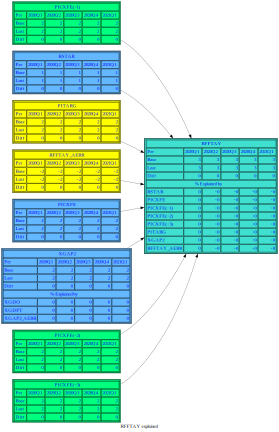

In [14]:
_ = mfrbus.rfftay.explain(up=1,svg=1,pdf=0)

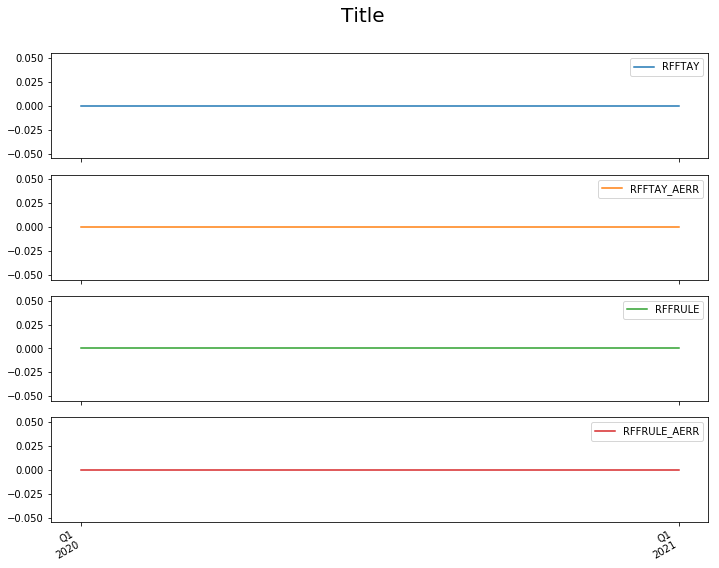

In [15]:
_ = mfrbus['rffta* rffrule*'].dif.plot(colrow=1,sharey=0)

In [16]:
#mfrbus.drawendo(lag=0,title='FRB/US endogeneous interpendencies',pdf=0)
# you will find the output files in different format in the /graph folder

# How is the interest rate determined

In [ ]:
mfrbus.RFF.draw(up=1,down=1,HR=0,svg=1)

# Show causal structure (only current year)

In [ ]:
fig   = draw_adjacency_matrix(mfrbus.endograph,mfrbus.precoreepiorder,
                                          mfrbus._superstrongblock,mfrbus._superstrongtype,size=(40,40))
#fig.savefig('graph/FRB-US causality structure.pdf')